In [95]:
!pip install xgboost lightgbm catboost --quiet


In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

# Dark theme
plt.style.use("dark_background")
sns.set_palette("bright")


In [97]:
# Load datasets
df_main = pd.read_csv("/content/weekly_features_engineered.csv")
df_raw = pd.read_csv("/content/Aroshas-weekly-dataset.csv")
df_pred = pd.read_csv("/content/Aroshas-weekly-Predictions.csv")

print("Main dataset shape:", df_main.shape)
print("Raw dataset shape:", df_raw.shape)
print("Predictions dataset shape:", df_pred.shape)

df_main.head()


Main dataset shape: (4758, 56)
Raw dataset shape: (4944, 44)
Predictions dataset shape: (936, 4)


,Date,Vegetable,Price,Year,Month,Week_of_Year,Quarter,Price_Lag_1,Price_Lag_2,Price_Lag_3,...,Fuel_Lag_4,Fuel_Rolling_Mean_4,Price_Change_12wk,Price_Change_Pct_4wk,Price_Change_Pct_12wk,Price_Acceleration,Volatility_Percentile,High_Volatility,Volatility_Change,Vegetable_Code
0,2010-01-11,Bitter Gourd,116.13,2010,1,2,1,114.12,0.00,0.00,...,NaN,121.0,116.13,inf,inf,NaN,0.011349,0.0,NaN,0
1,2010-01-18,Bitter Gourd,120.54,2010,1,3,1,116.13,114.12,0.00,...,NaN,121.0,120.54,inf,inf,2.40,0.071879,0.0,1.862631,0
2,2010-01-25,Bitter Gourd,115.14,2010,1,4,1,120.54,116.13,114.12,...,NaN,121.0,115.14,inf,inf,-9.81,0.056747,0.0,-0.457181,0
3,2010-02-01,Bitter Gourd,111.50,2010,2,5,1,115.14,120.54,116.13,...,NaN,121.0,111.50,-2.295829,inf,1.76,0.094578,0.0,0.892544,0
4,2010-02-08,Bitter Gourd,116.15,2010,2,6,1,111.50,115.14,120.54,...,121.0,121.0,116.15,0.017222,inf,8.29,0.095839,0.0,0.000556,0


In [98]:
df_main.info()
TARGET = "Price"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4758 entries, 0 to 4757
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      4758 non-null   object 
 1   Vegetable                 4758 non-null   object 
 2   Price                     4758 non-null   float64
 3   Year                      4758 non-null   int64  
 4   Month                     4758 non-null   int64  
 5   Week_of_Year              4758 non-null   int64  
 6   Quarter                   4758 non-null   int64  
 7   Price_Lag_1               4758 non-null   float64
 8   Price_Lag_2               4758 non-null   float64
 9   Price_Lag_3               4758 non-null   float64
 10  Price_Lag_4               4758 non-null   float64
 11  Price_Lag_8               4758 non-null   float64
 12  Price_Lag_12              4758 non-null   float64
 13  Price_Lag_52              4758 non-null   float64
 14  Rolling_

In [99]:
df_main["Date"] = pd.to_datetime(df_main["Date"])
df_main = df_main.sort_values("Date")

df_main = df_main.dropna()

df_main.reset_index(drop=True, inplace=True)

df_main.head()


,Date,Vegetable,Price,Year,Month,Week_of_Year,Quarter,Price_Lag_1,Price_Lag_2,Price_Lag_3,...,Fuel_Lag_4,Fuel_Rolling_Mean_4,Price_Change_12wk,Price_Change_Pct_4wk,Price_Change_Pct_12wk,Price_Acceleration,Volatility_Percentile,High_Volatility,Volatility_Change,Vegetable_Code
0,2010-02-08,Tomatoes,146.98,2010,2,6,1,163.02,121.95,114.02,...,121.0,121.0,-26.591429,15.332706,-15.320165,-57.11,0.546028,0.0,0.930503,5
1,2010-02-08,Carrot,101.59,2010,2,6,1,117.73,131.46,139.05,...,121.0,121.0,-158.039630,-24.681198,-60.871184,-2.41,0.510719,0.0,7.236773,3
2,2010-02-08,Cabbage,82.95,2010,2,6,1,88.98,90.71,97.44,...,121.0,121.0,-256.309259,-11.340316,-75.549672,-4.30,0.296343,0.0,2.263990,2
3,2010-02-08,Pumpkin,54.43,2010,2,6,1,59.15,60.50,56.34,...,121.0,121.0,-218.162593,-5.339130,-80.032473,-3.37,0.160151,0.0,0.907654,4
4,2010-02-08,Bitter Gourd,116.15,2010,2,6,1,111.50,115.14,120.54,...,121.0,121.0,116.150000,0.017222,inf,8.29,0.095839,0.0,0.000556,0


In [100]:
# Drop missing values first
df_main = df_main.dropna().reset_index(drop=True)

# Define target
TARGET = "Price"

# Drop non-numeric columns
X = df_main.drop(columns=["Date", "Vegetable", TARGET])
y = df_main[TARGET]

print(X.dtypes.unique())  # should show only float64 and int64

[dtype('int64') dtype('float64')]


In [101]:
import numpy as np

df_main.replace([np.inf, -np.inf], np.nan, inplace=True)
df_main = df_main.dropna().reset_index(drop=True)

print("After cleaning shape:", df_main.shape)

After cleaning shape: (4727, 56)


In [102]:
TARGET = "Price"

X = df_main.drop(columns=["Date", "Vegetable", TARGET])
y = df_main[TARGET]

print("Feature shape:", X.shape)
print("Any inf left:", np.isinf(X).sum().sum())
print("Any NA left:", X.isna().sum().sum())

Feature shape: (4727, 53)
Any inf left: 0
Any NA left: 0


In [103]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    metrics = {}
    metrics["Train RMSE"] = np.sqrt(mean_squared_error(y_train, y_pred_train))
    metrics["Test RMSE"]  = np.sqrt(mean_squared_error(y_test,  y_pred_test))
    metrics["Test MAE"]   = mean_absolute_error(y_test, y_pred_test)
    metrics["Test R2"]    = r2_score(y_test, y_pred_test)
    metrics["Test MAPE"]  = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

    return metrics

In [146]:
tscv = TimeSeriesSplit(n_splits=10)

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (4298, 53)
Test size: (429, 53)


In [147]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.01,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "alpha": 8,
    "lambda": 10,
    "seed": 42
    }

watchlist = [(dtrain, "train"), (dtest, "eval")]

xgb_model_native = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval=50
)

y_pred_train = xgb_model_native.predict(dtrain)
y_pred_test  = xgb_model_native.predict(dtest)

xgb_metrics = {
    "Train RMSE": np.sqrt(mean_squared_error(y_train, y_pred_train)),
    "Test RMSE":  np.sqrt(mean_squared_error(y_test,  y_pred_test)),
    "Test MAE":   mean_absolute_error(y_test, y_pred_test),
    "Test R2":    r2_score(y_test, y_pred_test),
    "Test MAPE":  np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
}
xgb_metrics


[0]	train-rmse:129.61229	eval-rmse:267.92073
[50]	train-rmse:85.94110	eval-rmse:178.13529
[100]	train-rmse:59.12698	eval-rmse:121.44721
[150]	train-rmse:42.81322	eval-rmse:84.81709
[200]	train-rmse:32.57656	eval-rmse:60.57566
[250]	train-rmse:26.22492	eval-rmse:45.99593
[300]	train-rmse:22.08852	eval-rmse:36.39231
[350]	train-rmse:19.12857	eval-rmse:30.42373
[400]	train-rmse:17.01171	eval-rmse:26.70462
[450]	train-rmse:15.38307	eval-rmse:24.46696
[500]	train-rmse:14.04544	eval-rmse:23.06714
[550]	train-rmse:12.93214	eval-rmse:21.96734
[600]	train-rmse:11.97974	eval-rmse:21.21648
[650]	train-rmse:11.15443	eval-rmse:20.58619
[700]	train-rmse:10.54546	eval-rmse:20.17458
[750]	train-rmse:9.97139	eval-rmse:19.84914
[800]	train-rmse:9.43713	eval-rmse:19.60143
[850]	train-rmse:8.93032	eval-rmse:19.40878
[900]	train-rmse:8.49361	eval-rmse:19.28582
[950]	train-rmse:8.07616	eval-rmse:19.20208
[1000]	train-rmse:7.66787	eval-rmse:19.11598
[1050]	train-rmse:7.32193	eval-rmse:19.03392
[1100]	train-r

{'Train RMSE': np.float64(6.092437488426003),
 'Test RMSE': np.float64(18.961467930640634),
 'Test MAE': 10.631486975283078,
 'Test R2': 0.9879428705056014,
 'Test MAPE': np.float64(2.271254840261045)}

[0]	train-rmse:129.61229	eval-rmse:267.92073
[50]	train-rmse:85.94110	eval-rmse:178.13529
[100]	train-rmse:59.12698	eval-rmse:121.44721
[150]	train-rmse:42.81322	eval-rmse:84.81709
[200]	train-rmse:32.57656	eval-rmse:60.57566
[250]	train-rmse:26.22492	eval-rmse:45.99593
[300]	train-rmse:22.08852	eval-rmse:36.39231
[350]	train-rmse:19.12857	eval-rmse:30.42373
[400]	train-rmse:17.01171	eval-rmse:26.70462
[450]	train-rmse:15.38307	eval-rmse:24.46696
[500]	train-rmse:14.04544	eval-rmse:23.06714
[550]	train-rmse:12.93214	eval-rmse:21.96734
[600]	train-rmse:11.97974	eval-rmse:21.21648
[650]	train-rmse:11.15443	eval-rmse:20.58619
[700]	train-rmse:10.54546	eval-rmse:20.17458
[750]	train-rmse:9.97139	eval-rmse:19.84914
[800]	train-rmse:9.43713	eval-rmse:19.60143
[850]	train-rmse:8.93032	eval-rmse:19.40878
[900]	train-rmse:8.49361	eval-rmse:19.28582
[950]	train-rmse:8.07616	eval-rmse:19.20208
[1000]	train-rmse:7.66787	eval-rmse:19.11598
[1050]	train-rmse:7.32193	eval-rmse:19.03392
[1100]	train-r

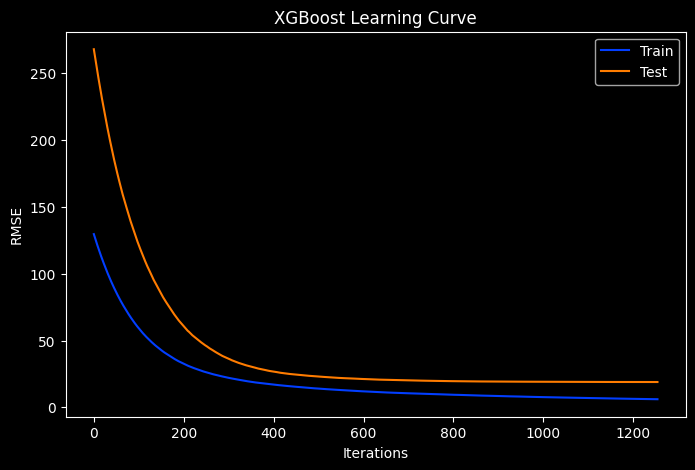

In [148]:
#  Create a dict to store evals results
evals_result = {}

xgb_model_native = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval=50,
    evals_result=evals_result   # <- pass the dict here
)

#  Now evals_result dict contains train/validation RMSE
plt.figure(figsize=(8,5))
plt.plot(evals_result['train']['rmse'], label='Train')
plt.plot(evals_result['eval']['rmse'], label='Test')
plt.title("XGBoost Learning Curve")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.legend()
plt.show()




In [149]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=6,
    num_leaves=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=2,
    reg_lambda=3,
    min_child_samples=20,
    random_state=42
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric="rmse",
    callbacks=[lgb.log_evaluation(0), lgb.early_stopping(50)]
)

lgb_metrics = evaluate_model(lgb_model, X_train, y_train, X_test, y_test)
lgb_metrics

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[517]	training's rmse: 15.1427	training's l2: 229.303	valid_1's rmse: 21.1252	valid_1's l2: 446.272


{'Train RMSE': np.float64(15.142743420257396),
 'Test RMSE': np.float64(21.125154736868488),
 'Test MAE': 10.549682155268048,
 'Test R2': 0.9850342043441233,
 'Test MAPE': np.float64(2.203277085665009)}

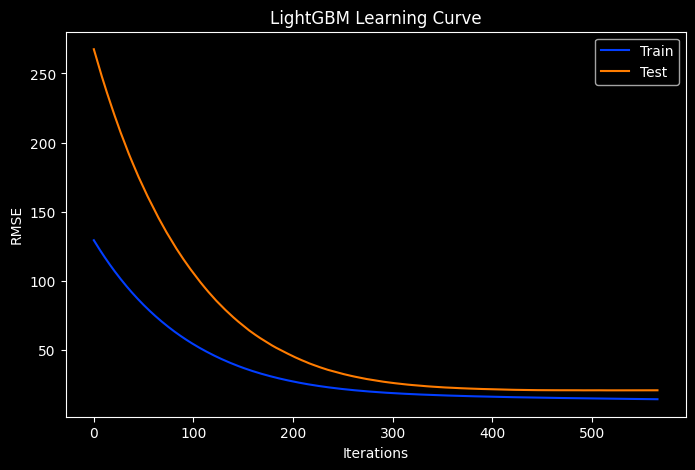

In [150]:
evals_result = lgb_model.evals_result_

plt.figure(figsize=(8,5))
plt.plot(evals_result['training']['rmse'], label='Train')
plt.plot(evals_result['valid_1']['rmse'],  label='Test')
plt.title("LightGBM Learning Curve")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [151]:
cat_model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.02,
    depth=5,
    l2_leaf_reg=12,
    random_seed=42,
    od_type='Iter',
    od_wait=50,
    verbose=False
)

cat_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False
)

cat_metrics = evaluate_model(cat_model, X_train, y_train, X_test, y_test)
cat_metrics


{'Train RMSE': np.float64(3.769724941877047),
 'Test RMSE': np.float64(17.485620660851694),
 'Test MAE': 10.475813833253882,
 'Test R2': 0.9897467365027115,
 'Test MAPE': np.float64(2.433171542258487)}

In [152]:
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator

tscv_cv = TimeSeriesSplit(n_splits=10)

# LightGBM CV
lgb_cv_scores = cross_val_score(
    lgb_model, X, y,
    cv=tscv_cv,
    scoring="neg_root_mean_squared_error"
)

# CatBoost CV
cat_cv_scores = cross_val_score(
    cat_model, X, y,
    cv=tscv_cv,
    scoring="neg_root_mean_squared_error"
)

print("LightGBM  — Mean CV RMSE:", round(-lgb_cv_scores.mean(), 4), "| Std:", round(lgb_cv_scores.std(), 4))
print("CatBoost  — Mean CV RMSE:", round(-cat_cv_scores.mean(), 4), "| Std:", round(cat_cv_scores.std(), 4))

LightGBM  — Mean CV RMSE: 22.1607 | Std: 23.0953
CatBoost  — Mean CV RMSE: 22.8146 | Std: 25.733


In [153]:
print("LightGBM best iteration:", lgb_model.best_iteration_)
print("CatBoost best iteration:", cat_model.best_iteration_)

LightGBM best iteration: 517
CatBoost best iteration: 1999


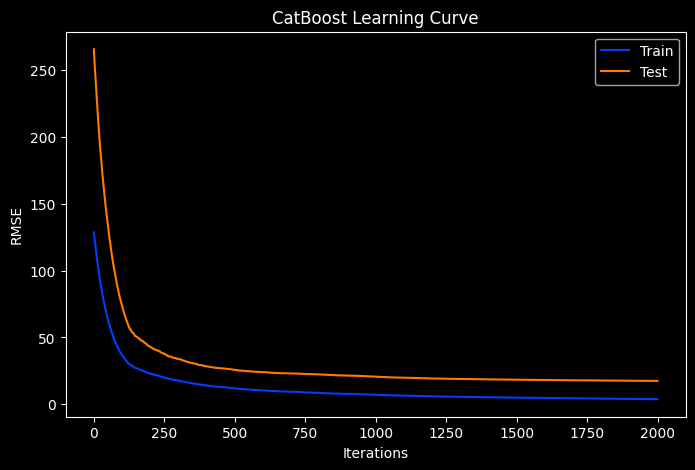

In [154]:
results = cat_model.get_evals_result()

plt.figure(figsize=(8,5))
plt.plot(results['learn']['RMSE'], label='Train')
plt.plot(results['validation']['RMSE'], label='Test')
plt.title("CatBoost Learning Curve")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.legend()
plt.show()


In [155]:
comparison = pd.DataFrame([xgb_metrics, lgb_metrics, cat_metrics],
                          index=["XGBoost", "LightGBM", "CatBoost"])

comparison.sort_values("Test RMSE")


,Train RMSE,Test RMSE,Test MAE,Test R2,Test MAPE
CatBoost,3.769725,17.485621,10.475814,0.989747,2.433172
XGBoost,6.092437,18.961468,10.631487,0.987943,2.271255
LightGBM,15.142743,21.125155,10.549682,0.985034,2.203277


In [159]:
import joblib
import os

# Create a folder to save models
os.makedirs("/content/baseline_models", exist_ok=True)

# Save LightGBM
joblib.dump(lgb_model, "/content/baseline_models/lgb_baseline.pkl")

# Save CatBoost
joblib.dump(cat_model, "/content/baseline_models/cat_baseline.pkl")

# Save XGBoost (native booster uses its own save method)
xgb_model_native.save_model("/content/baseline_models/xgb_baseline.json")

print("All baseline models saved:")
print("  /content/baseline_models/lgb_baseline.pkl")
print("  /content/baseline_models/cat_baseline.pkl")
print("  /content/baseline_models/xgb_baseline.json")

All baseline models saved:
  /content/baseline_models/lgb_baseline.pkl
  /content/baseline_models/cat_baseline.pkl
  /content/baseline_models/xgb_baseline.json


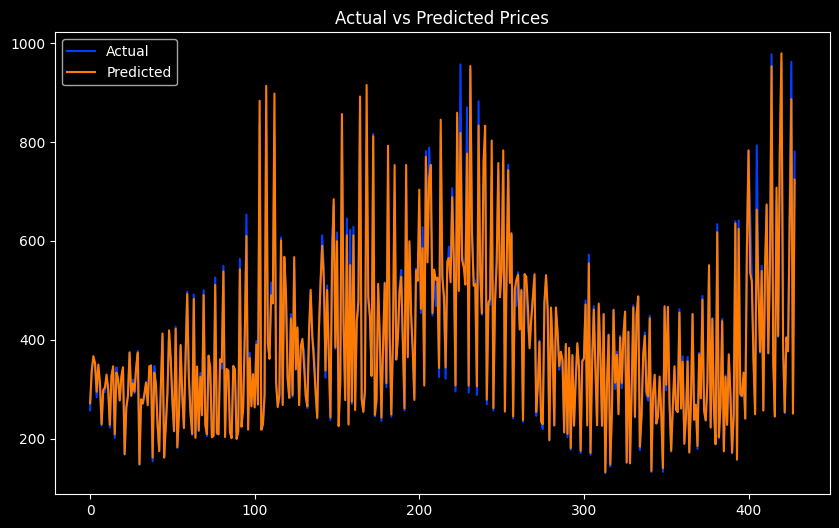

In [156]:
best_model = lgb_model

y_pred = best_model.predict(X_test)

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.show()


In [157]:
best_per_metric = comparison.idxmin()  # for RMSE, MAE, MAPE lower is better
best_per_metric['Test R2'] = comparison['Test R2'].idxmax()  # for R2, higher is better

best_per_metric


,0
Train RMSE,CatBoost
Test RMSE,CatBoost
Test MAE,CatBoost
Test R2,CatBoost
Test MAPE,LightGBM


In [158]:
ranks = comparison.rank(axis=0, ascending=[True, True, True, False])
avg_rank = ranks.mean(axis=1)
best_overall = avg_rank.idxmin()
best_overall



'CatBoost'